## 世界選手権のデータを可視化する③
---

In [1]:
%matplotlib inline
import pandas as pd
import os
import pymc as pm
import scipy
import matplotlib.pyplot as plt

### パラメータ

In [2]:
# 入力ファイル
input_dir_path = u"/Users/takayuki/Documents/work/Study/data/"
input_file_name = u"result_score_data.csv"
input_file_path = os.path.join(input_dir_path, input_file_name)

### データの読み込み

In [3]:
result_score_df = pd.read_csv(input_file_path)
result_score_df

,draw,sheet,team,hammer,end1,end2,end3,end4,end5,end6,...,end8,end9,end10,extra1,extra2,score(total),result,year,gender,game_ID
0,Draw #1,A,Sweden,1,0,0,0,0,0,0,...,1,0,X,NaN,NaN,1,-1,2010,Men,1
1,Draw #1,A,France,0,0,1,1,0,2,0,...,0,0,X,NaN,NaN,5,1,2010,Men,1
2,Draw #1,B,China,0,0,0,0,0,0,1,...,0,2,0,NaN,NaN,4,-1,2010,Men,2
3,Draw #1,B,Germany,1,0,0,1,1,1,0,...,1,0,1,NaN,NaN,5,1,2010,Men,2
4,Draw #1,C,Japan,0,0,1,0,1,1,0,...,0,0,1,0.0,NaN,6,-1,2010,Men,3
5,Draw #1,C,Italy,1,1,0,1,0,0,1,...,2,1,0,1.0,NaN,7,1,2010,Men,3
6,Draw #1,D,Norway,0,0,0,0,0,2,0,...,1,1,0,NaN,NaN,4,-1,2010,Men,4
7,Draw #1,D,Scotland,1,0,0,0,2,0,0,...,0,0,2,NaN,NaN,5,1,2010,Men,4
8,Draw #2,A,Italy,0,0,2,0,2,0,1,...,0,0,1,0.0,NaN,6,-1,2010,Men,5
9,Draw #2,A,China,1,1,0,2,0,0,0,...,0,1,0,1.0,NaN,7,1,2010,Men,5


### 先行／後攻別の勝ち数

In [46]:
# 先攻・後攻がわからないゲームは除く
print("--- data size ---")
print("data size: (%d, %d)" % result_score_df.shape)
filtered_result_score_df = result_score_df[result_score_df["hammer"] != -1]
print("data size(filetered): (%d, %d)" % filtered_result_score_df.shape)

# 勝敗数のカウント
cross_table = filtered_result_score_df.pivot_table(index="hammer", columns="result", values="draw", aggfunc="count")
cross_table["winning_percentage"] = cross_table[1] / (cross_table[-1] + cross_table[1])
print("\n")
print(u"--- 勝敗数 ---")
print(u"全試合：")
print(cross_table)

# 二項検定
success_num = cross_table.ix[1, 1]
failure_num = cross_table.ix[1, -1]
p_value = scipy.stats.binom_test([success_num, failure_num], p=0.5)
print("\n二項検定（帰無仮説：先行と後攻で勝率は変わらない, p=0.5）：")
print("p value: %.10f" % p_value)

--- data size ---
data size: (3746, 21)
data size(filetered): (3728, 21)


--- 勝敗数 ---
全試合：
result    -1     1  winning_percentage
hammer                                
0       1060   804             0.43133
1        804  1060             0.56867

二項検定（帰無仮説：先行と後攻で勝率は変わらない, p=0.5）：
p value: 0.0000000033


/Users/takayuki/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


### ベイズ推論

In [5]:
# 勝率（事前確率）
p_hammer = pm.Uniform('p_hammer', lower=0, upper=1)

# 観測データ
hammer_result_list = result_score_df[result_score_df["hammer"] == 1]["result"].tolist()
hammer_result_list = [True if x == 1 else False for x in hammer_result_list]
#hammer_result_list

# 観測データを設定
obs = pm.Bernoulli("obs", p_hammer, value=hammer_result_list, observed=True)

In [6]:
mcmc = pm.MCMC([p_hammer, obs])
mcmc.sample(10000, 1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.1 sec

### 勝率（事後確率）の分布を描画

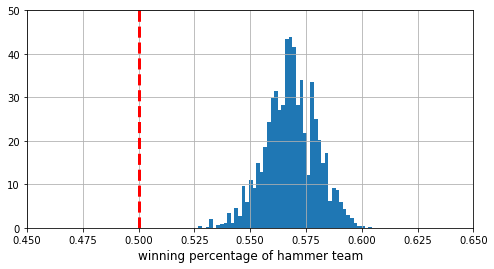

In [7]:
y_max = 50

fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(111)
plt.hist(mcmc.trace("p_hammer")[:], bins=50, histtype="stepfilled", normed=True)
plt.xlim(0.45, 0.65)
plt.ylim(0, y_max)
plt.xlabel("winning percentage of hammer team", fontsize=12)
plt.grid()

plt.vlines(0.50, 0, y_max, linestyles="--", lw=3, colors="r")

plt.show()

### パラメータの軌跡を描画

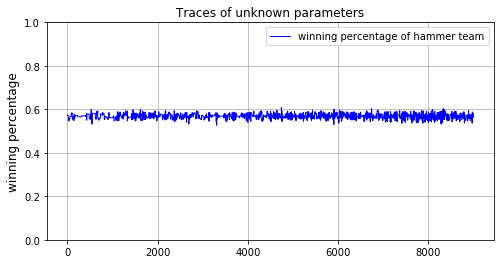

In [8]:
line_width = 1

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)

plt.plot(mcmc.trace("p_hammer")[:], label="winning percentage of hammer team", c="b", lw=line_width)
plt.grid()
plt.title("Traces of unknown parameters", fontsize=12)
plt.ylabel("winning percentage", fontsize=12)
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.ylim(0, 1)
plt.legend()

plt.show()

### 勝率がx割を超える確率

In [9]:
# 5割5分を超える確率
print("p > 0.55: %.2f" % (mcmc.trace("p_hammer")[:] - 0.55 >= 0).mean())

# 5割6分を超える確率
print("p > 0.56: %.2f" % (mcmc.trace("p_hammer")[:] - 0.56 >= 0).mean())

# 5割7分を超える確率
print("p > 0.57: %.2f" % (mcmc.trace("p_hammer")[:] - 0.57 >= 0).mean())

# 5割8分を超える確率
print("p > 0.58: %.2f" % (mcmc.trace("p_hammer")[:] - 0.58 >= 0).mean())

p > 0.55: 0.94
p > 0.56: 0.77
p > 0.57: 0.43
p > 0.58: 0.16


### 各国の先行／後攻別の勝率

In [10]:
# 国別に集計
cross_table = filtered_result_score_df.pivot_table(index=["team", "hammer"], columns="result", values="draw", aggfunc="count")

# NaNは0勝または0敗に変換
cross_table[1] = [x if x == x else 0 for x in cross_table[1]]
cross_table[-1] = [x if x == x else 0 for x in cross_table[-1]]

# indexを振り直す
cross_table.reset_index(inplace=True)

# 勝率を計算
cross_table["winning_percentage"] = cross_table[1] / (cross_table[-1] + cross_table[1])

# 日本、カナダの勝率
print("勝率(Japan)：")
print(cross_table.ix[cross_table["team"] == "Japan"][["hammer", -1, 1, "winning_percentage"]])
print("\n勝率(Canada)：")
print(cross_table.ix[cross_table["team"] == "Canada"][["hammer", -1, 1, "winning_percentage"]])

# カイ二乗検定
print("\nx2検定（勝敗と先行／後攻）")

# 日本
cross_tab_jp = cross_table.ix[cross_table["team"] == "Japan"][[-1, 1]]
cross_tab_jp.index = cross_table[cross_table["team"] == "Japan"]["hammer"]
x2, p, dof, expected = scipy.stats.chi2_contingency(cross_tab_jp)
print("日本：")
print("  x2値：{0}".format(x2))
print("  p値：{0}".format(p))

# カナダ
cross_tab_ca = cross_table.ix[cross_table["team"] == "Canada"][[-1, 1]]
cross_tab_ca.index = cross_table[cross_table["team"] == "Canada"]["hammer"]
x2, p, dof, expected = scipy.stats.chi2_contingency(cross_tab_ca)
print("\nカナダ：")
print("  x2値：{0}".format(x2))
print("  p値：{0}".format(p))

勝率(Japan)：
result  hammer    -1     1  winning_percentage
22           0  65.0  40.0            0.380952
23           1  57.0  39.0            0.406250

勝率(Canada)：
result  hammer    -1      1  winning_percentage
4            0  47.0  118.0            0.715152
5            1  36.0  162.0            0.818182

x2検定（勝敗と先行／後攻）
日本：
  x2値：0.04938619545400616
  p値：0.8241348018300338

カナダ：
  x2値：4.848460628227196
  p値：0.02767081651931886


/Users/takayuki/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


### ベイズ推論

In [14]:
#--- 日本 ---
p_hammer_jp = pm.Uniform('p_hammer_jp', lower=0, upper=1)
p_not_hammer_jp = pm.Uniform('p_not_hammer_jp', lower=0, upper=1)

# 観測データ
result_score_jp_df = result_score_df[result_score_df["team"] == "Japan"]
hammer_result_jp_list = result_score_jp_df[result_score_jp_df["hammer"] == 1]["result"].tolist()
hammer_result_jp_list = [True if x == 1 else False for x in hammer_result_jp_list]
not_hammer_result_jp_list = result_score_jp_df[result_score_jp_df["hammer"] == 0]["result"].tolist()
not_hammer_result_jp_list = [True if x == 1 else False for x in not_hammer_result_jp_list]

# 差分
@pm.deterministic
def p_diff_jp(p_hammer_jp=p_hammer_jp, p_not_hammer_jp=p_not_hammer_jp):
    return p_hammer_jp - p_not_hammer_jp

# 観測データを設定
obs_hammer_jp = pm.Bernoulli("obs_hammer_jp", p_hammer_jp, value=hammer_result_jp_list, observed=True)
obs_not_hammer_jp = pm.Bernoulli("obs_not_hammer_jp", p_not_hammer_jp, value=not_hammer_result_jp_list, observed=True)

In [15]:
mcmc_jp = pm.MCMC([p_hammer_jp, p_not_hammer_jp, obs_hammer_jp, obs_not_hammer_jp, p_diff_jp])
mcmc_jp.sample(10000, 1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.4 sec

### 勝率の描画

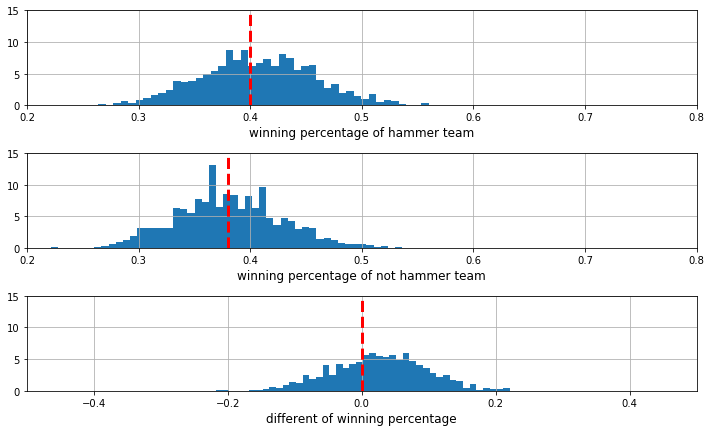

In [37]:
y_max = 15
x_lim = (0.2, 0.8)

fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(hspace=0.5)

# hammer
ax = fig.add_subplot(311)
plt.hist(mcmc_jp.trace("p_hammer_jp")[:], bins=50, histtype="stepfilled", normed=True)
plt.vlines(0.40, 0, y_max, linestyles="--", lw=3, colors="r")
plt.xlim(x_lim)
plt.ylim(0, y_max)
plt.xlabel("winning percentage of hammer team", fontsize=12)
plt.grid()

# not hammer
ax = fig.add_subplot(312)
plt.hist(mcmc_jp.trace("p_not_hammer_jp")[:], bins=50, histtype="stepfilled", normed=True)
plt.vlines(0.38, 0, y_max, linestyles="--", lw=3, colors="r")
plt.xlim(x_lim)
plt.ylim(0, y_max)
plt.xlabel("winning percentage of not hammer team", fontsize=12)
plt.grid()

# different of p
ax = fig.add_subplot(313)
plt.hist(mcmc_jp.trace("p_diff_jp")[:], bins=50, histtype="stepfilled", normed=True)
plt.vlines(0.0, 0, y_max, linestyles="--", lw=3, colors="r")
plt.xlim(-0.5, 0.5)
plt.ylim(0, y_max)
plt.xlabel("different of winning percentage", fontsize=12)
plt.grid()

plt.show()

In [20]:
#--- カナダ ---
p_hammer_ca = pm.Uniform('p_hammer_ca', lower=0, upper=1)
p_not_hammer_ca = pm.Uniform('p_not_hammer_ca', lower=0, upper=1)

# 観測データ
result_score_ca_df = result_score_df[result_score_df["team"] == "Canada"]
hammer_result_ca_list = result_score_ca_df[result_score_ca_df["hammer"] == 1]["result"].tolist()
hammer_result_ca_list = [True if x == 1 else False for x in hammer_result_ca_list]
not_hammer_result_ca_list = result_score_ca_df[result_score_ca_df["hammer"] == 0]["result"].tolist()
not_hammer_result_ca_list = [True if x == 1 else False for x in not_hammer_result_ca_list]

# 差分
@pm.deterministic
def p_diff_ca(p_hammer_ca=p_hammer_ca, p_not_hammer_ca=p_not_hammer_ca):
    return p_hammer_ca - p_not_hammer_ca

# 観測データを設定
obs_hammer_ca = pm.Bernoulli("obs_hammer_ca", p_hammer_ca, value=hammer_result_ca_list, observed=True)
obs_not_hammer_ca = pm.Bernoulli("obs_not_hammer_ca", p_not_hammer_ca, value=not_hammer_result_ca_list, observed=True)

In [21]:
mcmc_ca = pm.MCMC([p_hammer_ca, p_not_hammer_ca, obs_hammer_ca, obs_not_hammer_ca, p_diff_ca])
mcmc_ca.sample(10000, 1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.5 sec

### 勝率の描画

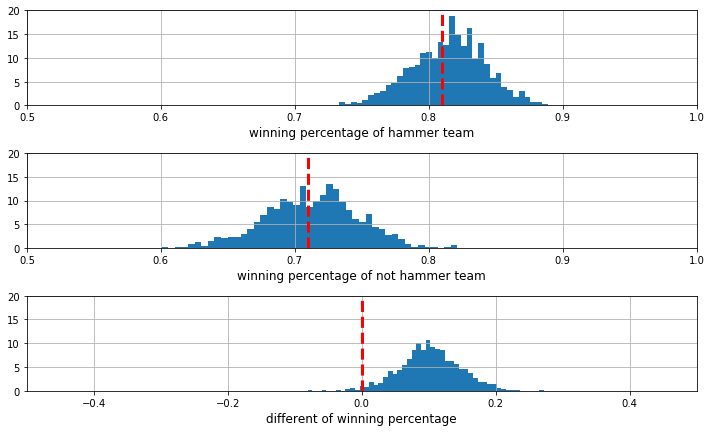

In [35]:
y_max = 20
x_lim = (0.5, 1.0)

fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(hspace=0.5)

# hammer
ax = fig.add_subplot(311)
plt.hist(mcmc_ca.trace("p_hammer_ca")[:], bins=50, histtype="stepfilled", normed=True)
plt.vlines(0.81, 0, y_max, linestyles="--", lw=3, colors="r")
plt.xlim(x_lim)
plt.ylim(0, y_max)
plt.xlabel("winning percentage of hammer team", fontsize=12)
plt.grid()

# differentof p
ax = fig.add_subplot(312)
plt.hist(mcmc_ca.trace("p_not_hammer_ca")[:], bins=50, histtype="stepfilled", normed=True)
plt.vlines(0.71, 0, y_max, linestyles="--", lw=3, colors="r")
plt.xlim(x_lim)
plt.ylim(0, y_max)
plt.xlabel("winning percentage of not hammer team", fontsize=12)
plt.grid()

# different of p
ax = fig.add_subplot(313)
plt.hist(mcmc_ca.trace("p_diff_ca")[:], bins=50, histtype="stepfilled", normed=True)
plt.vlines(0.0, 0, y_max, linestyles="--", lw=3, colors="r")
plt.xlim(-0.5, 0.5)
plt.ylim(0, y_max)
plt.xlabel("different of winning percentage", fontsize=12)
plt.grid()

plt.show()

In [43]:
cross_table.ix[1, -1]

804

In [42]:
cross_table

result,-1,1,winning_percentage
hammer,,,
0,1060,804,0.43133
1,804,1060,0.56867
